# Estimating Model Performance Without Labels

In this notebook we show how we can use the `PerformancePredictor` class from mercury.monitoring in order to estimate the performance of a model on unlabeled data. For example, it can be used to monitor model performance in production data when we still don't have the real labels.

The method is based on the paper [Learning to Validate the Predictions of Black Box Classifiers on Unseen Data](https://ssc.io/pdf/mod0077s.pdf). In a nutshell, the steps of the method are:

1. Apply corruptions to a held-out (labeled) dataset
2. Obtain percentiles of model outputs and the performance of the model when applying these corruptions
3. Train a regressor model to predict model performance. The samples to train this model are the percentiles and performances of the model obtained in 2.
4. Use the trained regressor to estimate the performance on serving unlabeled data

According to the paper, the method works well when: 1) We have a situation of covariate shift (changes in input data distributions) and 2) We know in advance what kind of covariate shift we can find in our serving data

However, in our experiments we have found that in some situations the method still works fine when the data also suffers from label shift. At the same time, it's important to mention that the method is not 100% accurate and cannot detect performance drops in all cases. Therefore, we believe that it can be useful as one more signal to monitor in the scenarios  where we do not have labels in the short term (for example to trigger model retraining) but not as a accurate metric for reporting.

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

from matplotlib import pyplot as plt
import seaborn as sns

SEED = 123

Next, we will show 3 experiments:


[Experiment 1: Synthetic Dataset (MultiClass Classification)](#experiment_1)

[Experiment 2: High Quality Wines Prediction (Binary Classification)](#experiment_2)

[Experiment 3: Regression in synthetic Dataset](#experiment_3)

<a id="experiment_1"></a>
## Experiment 1: Synthetic Dataset (MultiClass Classification)

This experiment will show how the method works by using a synthetic dataset for multiclass classification. This will be useful for illustration purposes. Note that in this experiment we will manually specify the possible data shifts that our dataset may experience in our serving data (more about this latter). This will be different from experiment 2, where data shifts will be automatically set from detection drift in serving data

### Create Dataset

Let's create a dataset with 3 possible classes as labels:

In [2]:
from sklearn.datasets import make_classification
X, y = make_classification(
    n_samples=10_000, n_features=3, n_informative=3, n_redundant=0, n_classes=3, random_state=SEED
)
X = pd.DataFrame(X, columns=["f" + str(i) for i in range(X.shape[1])])

We split the dataset in Source and Serving sets. Source will be used to train the model, evaluating, and to fit our performance predictor. Serving will be used to simulate the serving data and use or performance predictor on it.

In [3]:
from sklearn.model_selection import train_test_split
X_source, X_serving, y_source, y_serving = train_test_split(X, y, test_size=0.4, random_state=SEED)

We further split the serving set in 4. We will introduce some data drift in the last 3 sets.

In [4]:
X_serving_1 = X_serving.iloc[0:1000].copy()
X_serving_2 = X_serving.iloc[1000:2000].copy()
X_serving_3 = X_serving.iloc[2000:3000].copy()
X_serving_4 = X_serving.iloc[3000:4000].copy()

y_serving_1 = y_serving[0:1000]
y_serving_2 = y_serving[1000:2000]
y_serving_3 = y_serving[2000:3000]
y_serving_4 = y_serving[3000:4000]

A way to introduce drift in datasets is to use the `BatchDriftGenerator` component.



In [5]:
from mercury.monitoring.drift.drift_simulation import BatchDriftGenerator

# Shift Drift in Feature f0 in X_serving_2
sim = BatchDriftGenerator(X_serving_2.copy()).shift_drift(cols=["f0"], force=5.0, noise=1.0)
X_serving_2 = sim.data.copy()

# Scale Drift in Feature f1 in X_serving_3
sim = BatchDriftGenerator(X_serving_3.copy()).scale_drift(cols=["f1"], mean=5.0, sd=0.05)
X_serving_3 = sim.data.copy()

# Outliers in Feature f2 in X_serving_4
sim = BatchDriftGenerator(X_serving_4.copy()).outliers_drift(
    cols=["f2"], method="percentile", method_params={'percentile': 0.99, 'proportion_outliers': 0.25})
X_serving_4 = sim.data.copy()

### Train Model

Now, let's split the source set. We will keep a held-out dataset to evaluate the dataset and train the `PerformancePredictor`

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_source, y_source, test_size=0.3, random_state=SEED)

In [7]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=5, n_estimators=20, random_state=SEED)
model = model.fit(X_train, y_train)

In [8]:
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, model.predict(X_test))

print(acc_train, " - ", acc_test)

0.8116666666666666  -  0.7977777777777778


### Apply Performance Predictor

Now, it's time to apply our `PerformancePredictor`

<b> Define possible Expected Corruptions </b>

As we were mentioning, in this experiment we will define corruptions of the dataset that we think that could happen in our serving data. This will be different from experiment 2, where the corruptions will be automatically generated. By specifying the corruptions similar to what then happens in our serving data the method will be able to make a better estimation of the model performance.

In order to specify the corruptions, we need to specify a list of tuples where each element is a corruption specified by:

1. A string with the type of drift to apply 
2. A dictionary with the parameters of the drift to apply.

For the first element, the type of drift you can use any method available in `BatchDriftGenerator` class. In the second element, the parameters are the arguments of the drift function, for example, for 'shift_drift' we have `cols`, `force` and `noise`

In this case, we define `shift_drift` for 'f0', `scale_drift` for 'f1' and `outliers_drift` for 'f2', which corresponds to the drift that we applied before on our Serving sets

In [9]:
corruptions = [
    ('shift_drift', {'cols': ['f0'], 'force': 0.0, 'noise': 0.01}),
    ('shift_drift', {'cols': ['f0'], 'force': 0.2, 'noise': 0.05}),
    ('shift_drift', {'cols': ['f0'], 'force': 1.0, 'noise': 0.1}),
    ('shift_drift', {'cols': ['f0'], 'force': 2.0, 'noise': 0.1}),
    ('shift_drift', {'cols': ['f0'], 'force': 5.0, 'noise': 0.1}),
    ('shift_drift', {'cols': ['f0'], 'force': 10.0, 'noise': 0.1}),
    ('shift_drift', {'cols': ['f0'], 'force': 15.0, 'noise': 0.1}),
    ('shift_drift', {'cols': ['f0'], 'force': 20.0, 'noise': 0.1}),
    ('scale_drift', {'cols': ['f1'], 'mean': 0.1, 'sd': 0.01}),
    ('scale_drift', {'cols': ['f1'], 'mean': 0.5, 'sd': 0.01}),
    ('scale_drift', {'cols': ['f1'], 'mean': 0.7, 'sd': 0.01}),
    ('scale_drift', {'cols': ['f1'], 'mean': 0.9, 'sd': 0.01}),
    ('scale_drift', {'cols': ['f1'], 'mean': 1.1, 'sd': 0.01}),
    ('scale_drift', {'cols': ['f1'], 'mean': 1.3, 'sd': 0.01}),
    ('scale_drift', {'cols': ['f1'], 'mean': 1.5, 'sd': 0.01}),
    ('scale_drift', {'cols': ['f1'], 'mean': 2.0, 'sd': 0.01}),
    ('scale_drift', {'cols': ['f1'], 'mean': 3.0, 'sd': 0.01}),
    ('scale_drift', {'cols': ['f1'], 'mean': 4.0, 'sd': 0.01}),
    ('scale_drift', {'cols': ['f1'], 'mean': 5.0, 'sd': 0.01}),
    ('scale_drift', {'cols': ['f1'], 'mean': 10.0, 'sd': 0.01}),
    ('outliers_drift', {'cols': ['f2'], 'method': 'percentile', 'method_params': {'proportion_outliers': 0.15}}),
    ('outliers_drift', {'cols': ['f2'], 'method': 'percentile', 'method_params': {'proportion_outliers': 0.20}}),
    ('outliers_drift', {'cols': ['f2'], 'method': 'percentile', 'method_params': {'proportion_outliers': 0.25}}),
    ('outliers_drift', {'cols': ['f2'], 'method': 'percentile', 'method_params': {'proportion_outliers': 0.35}}),
    ('outliers_drift', {'cols': ['f2'], 'method': 'percentile', 'method_params': {'proportion_outliers': 0.40}}),
    ('outliers_drift', {'cols': ['f2'], 'method': 'percentile', 'method_params': {'proportion_outliers': 0.50}}),
    ('outliers_drift', {'cols': ['f2'], 'method': 'percentile', 'method_params': {'proportion_outliers': 0.60}}),
]

Let's create the `PerformancePredictor`. We specify the model, the metric that we want to estimate (accuracy in this case), the corruptions that we defined, and the optional `random_state`. The are other optional arguments that you can specify: for example you can specify a `performance_predictor` in order to use a different model as performance predictor regressor (by default it uses a `RandomForestRegressor`). You can check the class documention for more details.


In [10]:
from mercury.monitoring.estimation.performance_predictor import PerformancePredictor
performance_predictor = PerformancePredictor(
    model, 
    metric_fn=accuracy_score, 
    corruptions=corruptions,
    random_state=SEED
)

We use our test dataset to fit our performance predictor. Corruptions will be applied on this dataset

In [11]:
performance_predictor.fit(X=X_test, y=y_test)

Now, let's predict the performance in all serving datasets and compare with the real performance 

In [12]:
predicted_acc_1 = performance_predictor.predict(X_serving_1)[0]
predicted_acc_2 = performance_predictor.predict(X_serving_2)[0]
predicted_acc_3 = performance_predictor.predict(X_serving_3)[0]
predicted_acc_4 = performance_predictor.predict(X_serving_4)[0]

real_acc_1 = accuracy_score(y_serving_1, model.predict(X_serving_1))
real_acc_2 = accuracy_score(y_serving_2, model.predict(X_serving_2))
real_acc_3 = accuracy_score(y_serving_3, model.predict(X_serving_3))
real_acc_4 = accuracy_score(y_serving_4, model.predict(X_serving_4))

predicted_acc_all = [predicted_acc_1, predicted_acc_2, predicted_acc_3, predicted_acc_4]
real_acc_all = [real_acc_1, real_acc_2, real_acc_3, real_acc_4]
df_acc = pd.DataFrame.from_dict({'real_acc': real_acc_all, 'predicted_acc': predicted_acc_all})
df_acc

,real_acc,predicted_acc
0,0.797,0.792426
1,0.512,0.518296
2,0.693,0.665889
3,0.704,0.780926


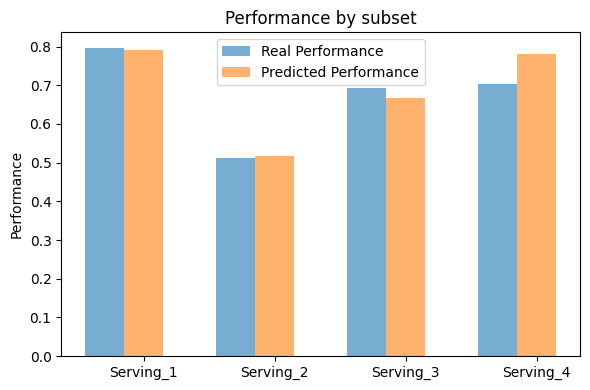

In [13]:
# data to plot
real_performance = df_acc.real_acc.values
predicted_performance = df_acc.predicted_acc.values

# create plot
fig, ax = plt.subplots(figsize=(6, 4))
index = np.arange(len(real_performance))
bar_width = 0.30

bar1 = plt.bar(index, real_performance, bar_width, alpha=0.6, label='Real Performance')
bar2 = plt.bar(index + bar_width, predicted_performance, bar_width,alpha=0.6, label='Predicted Performance')

plt.ylabel('Performance')
plt.title('Performance by subset')
plt.xticks(index + bar_width, ('Serving_1', 'Serving_2', 'Serving_3', 'Serving_4'))
plt.legend()

plt.tight_layout()
plt.show()

As we see, in this case the performance is not predicted exactly, but the method is able to detect some performance drops

<a id="experiment_2"></a>
## Experiment 2: High Quality Wines Prediction (Binary Classification)


Now we will apply the method to the wine quality dataset [[1]](#[1]) dataset. The files of this dataset are available inside of the /data/winequality folder in tutorials and it is also available in the [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/wine+quality) 

In this dataset, each row of the dataset represents a different wine and it contains attributes like the acidity of the wine or the level of alcohol. The dataset also contains the quality of the wine, ranging from 0 to 10. We convert this quality to an integer to indicate if it is a high-quality wine or not. We suppose that we have the goal of building a model to predict if a wine will be a high-quality wine given its attributes.

Importantly, we will introduce drift in this dataset. We will do that by creating a time column and gradually changing the a amount of wines with a high level of alcohol.

An important difference from this experiment is that we don't specify the corruptions manually. We will let the method to generate the corruptions by itself by looking at the serving data and creating the corruptions by detecting variables with drift.


### Load and Prepare Dataset


In [14]:
df_red_wines = pd.read_csv("../data/winequality/winequality-red.csv")
df_white_wines = pd.read_csv("../data/winequality/winequality-white.csv")

df_red_wines["type"] = "red"
df_white_wines["type"] = "white"

df = pd.concat([df_red_wines, df_white_wines])

Now, we create some data drift in the dataset. As we mentioned, we gradually increase the number of wines with high level of alcohol over time:

In [15]:
# Create id
df["id"] = np.arange(df.shape[0])

# Encode Label
df["quality"] = df["quality"].apply(lambda x: 1 if x >=7 else 0)

# Encode Type
le = preprocessing.LabelEncoder()
df["type"] = le.fit_transform(df["type"])

# Set attribute to indicate high alcohol
df["high_alcohol"] = df["alcohol"].apply(lambda x: True if x > 11 else False)

# Time will represent the moment we have that data
df["time"] = -1

# For those rows with high alcohol, we set 70% of them as time 0 (they will be used as training)
df["time"] = df.apply(
    lambda x: 0 if (x["high_alcohol"] == False) and (np.random.uniform() < 0.7) else -1, axis=1
 )

# Each timestep, new amount of samples low_alcohol and high_alcohol
n_samples_low_alcohol = [250, 245, 230, 210, 180, 140, 30]
n_samples_high_alcohol = [0, 5, 10, 20, 40, 80, 160]
max_timesteps = 7
for t in range(1, max_timesteps + 1):
    # Sample examples with high_alcohol == True
    n_samples = n_samples_high_alcohol[t-1]
    sampled_ids = df[(df["time"] == -1) & (df["high_alcohol"] == True)].sample(
        n_samples, random_state=2021)["id"].values
    df.loc[df["id"].isin(sampled_ids), "time"] = t
    # Sample examples with high_alcohol == False
    n_samples = n_samples_low_alcohol[t-1]
    sampled_ids = df[(df["time"] == -1) & (df["high_alcohol"] == False)].sample(
        n_samples, random_state=2021)["id"].values
    df.loc[df["id"].isin(sampled_ids), "time"] = t

As we see, we see start with zero wines of high level of alcohol and we end up with more wines of high level of alcohol than low level:

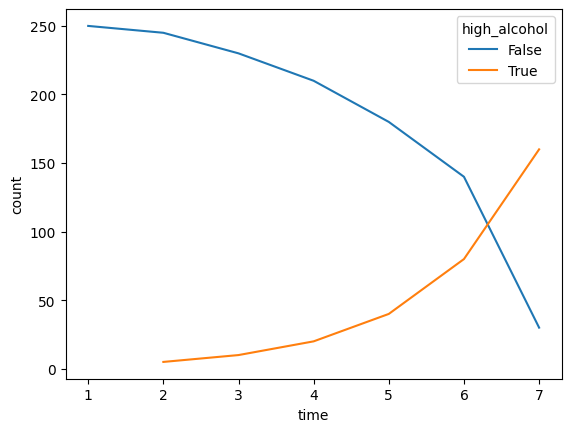

In [16]:
sample_counts = df.groupby(["time", "high_alcohol"])["id"].count().to_frame().reset_index()
sample_counts = sample_counts.rename(columns={"id": "count"})
sample_counts = sample_counts[sample_counts["time"] > 0]
ax = sns.lineplot(x="time", y="count", hue="high_alcohol", data=sample_counts)

Note that by introducing this data drift, we unintentionally introduced label shift: the proportion of wines of high quality increases considerably in the last time steps:

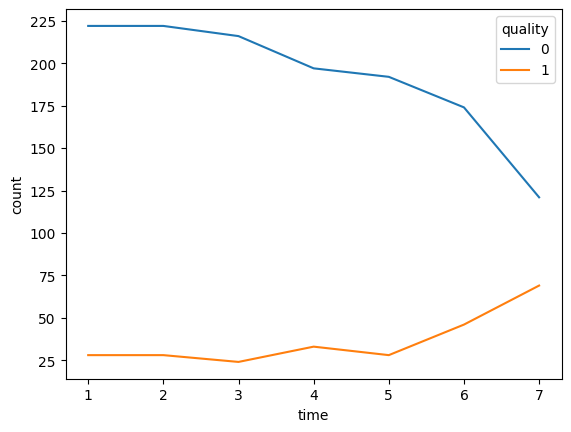

In [17]:
sample_counts = df.groupby(["time", "quality"])["id"].count().to_frame().reset_index()
sample_counts = sample_counts.rename(columns={"id": "count"})
sample_counts = sample_counts[sample_counts["time"] > 0]
ax = sns.lineplot(x="time", y="count", hue="quality", data=sample_counts)

This makes the performance prediction more challenging

### Train Model

We will use the data from timestep 0 to train the model

In [18]:
df_source = df[df["time"] == 0]
df_serving = df[df["time"] > 0]

print(df_source.shape)
print(df_serving.shape)

(3118, 16)
(1600, 16)


Now, let's split the source set. We will keep a held-out dataset to evaluate the dataset and train the `PerformancePredictor`

In [19]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_source, test_size=0.3, random_state=SEED)

In [20]:
features = [
    'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
    'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
    'pH', 'sulphates', 'alcohol'
]
label = "quality"

In this case, we will train 3 models, so we can compare latter if the performance of the model is accurately predicted in all of them

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

m1 = Pipeline(
    steps=[
        ("preprocessor", StandardScaler()),
        ("classifier", LogisticRegression(class_weight='balanced', random_state=SEED))
    ]
)
m2 = RandomForestClassifier(max_depth=8, min_samples_split=5, class_weight='balanced', random_state=SEED)

m3 = DecisionTreeClassifier(max_depth=5, min_samples_split=8, class_weight='balanced', random_state=SEED)

m1 = m1.fit(df_train[features], df_train[label].values)
m2 = m2.fit(df_train[features], df_train[label].values)
m3 = m3.fit(df_train[features], df_train[label].values)

In [22]:
from sklearn.metrics import accuracy_score

acc_train_m1 = accuracy_score(df_train[label].values, m1.predict(df_train[features]))
acc_train_m2 = accuracy_score(df_train[label].values, m2.predict(df_train[features]))
acc_train_m3 = accuracy_score(df_train[label].values, m3.predict(df_train[features]))

acc_test_m1 = accuracy_score(df_test[label].values, m1.predict(df_test[features]))
acc_test_m2 = accuracy_score(df_test[label].values, m2.predict(df_test[features]))
acc_test_m3 = accuracy_score(df_test[label].values, m3.predict(df_test[features]))

print(acc_train_m1, " - ", acc_test_m1)
print(acc_train_m2, " - ", acc_test_m2)
print(acc_train_m3, " - ", acc_test_m3)

0.6681943171402384  -  0.6901709401709402
0.96012832263978  -  0.8931623931623932
0.6956920256645279  -  0.6399572649572649


### Apply Performance Predictor

Now, let's apply the `PerformancePredictor` to estimate the performance of the three models in all timesteps. In this case, we do not specify the corruptions as we did in experiment 1.

Note that now, when calling the `fit` method in the `PerformancePredictor` we specify the serving dataset (for that timestep). That will make that corruptions will be added according to the data drift detected between the held-out set specified (`X` argument) and the serving dataset (`X_serving` argument). If no data drift is detected, a set of default corruptions are generated (you will see some warnings for this reason).

In [24]:
%%time
from mercury.monitoring.estimation.performance_predictor import PerformancePredictor

real_accs_m1 = []
real_accs_m2 = []
real_accs_m3 = []
predicted_accs_m1 = []
predicted_accs_m2 = []
predicted_accs_m3 = []
for t in range(1,8):

    X_serving = df_serving[df_serving["time"] == t][features]
    y_serving = df_serving[df_serving["time"] == t][label].values

    # Create PerfomancePredictor
    performance_predictor_m1 = PerformancePredictor(m1, metric_fn=accuracy_score, random_state=SEED)
    performance_predictor_m2 = PerformancePredictor(m2, metric_fn=accuracy_score, random_state=SEED)
    performance_predictor_m3 = PerformancePredictor(m3, metric_fn=accuracy_score, random_state=SEED)
    
    # Fit
    performance_predictor_m1.fit(X=df_test[features], y=df_test[label], X_serving=X_serving)
    performance_predictor_m2.fit(X=df_test[features], y=df_test[label], X_serving=X_serving)
    performance_predictor_m3.fit(X=df_test[features], y=df_test[label], X_serving=X_serving)
    
    # Predict performance
    predicted_acc_m1 = performance_predictor_m1.predict(X_serving)
    predicted_acc_m2 = performance_predictor_m2.predict(X_serving)
    predicted_acc_m3 = performance_predictor_m3.predict(X_serving)
    
    # Real performance
    real_acc_m1= accuracy_score(y_serving, m1.predict(X_serving))
    real_acc_m2= accuracy_score(y_serving, m2.predict(X_serving))
    real_acc_m3= accuracy_score(y_serving, m3.predict(X_serving))

    # ADD TO LIST
    real_accs_m1.append(real_acc_m1)
    real_accs_m2.append(real_acc_m2)
    real_accs_m3.append(real_acc_m3)
    predicted_accs_m1.append(predicted_acc_m1)
    predicted_accs_m2.append(predicted_acc_m2)
    predicted_accs_m3.append(predicted_acc_m3)

CPU times: user 1min 14s, sys: 7.35 s, total: 1min 21s
Wall time: 56.4 s


Let's plot a chart to compare the estimated with the real accuracy for each model:

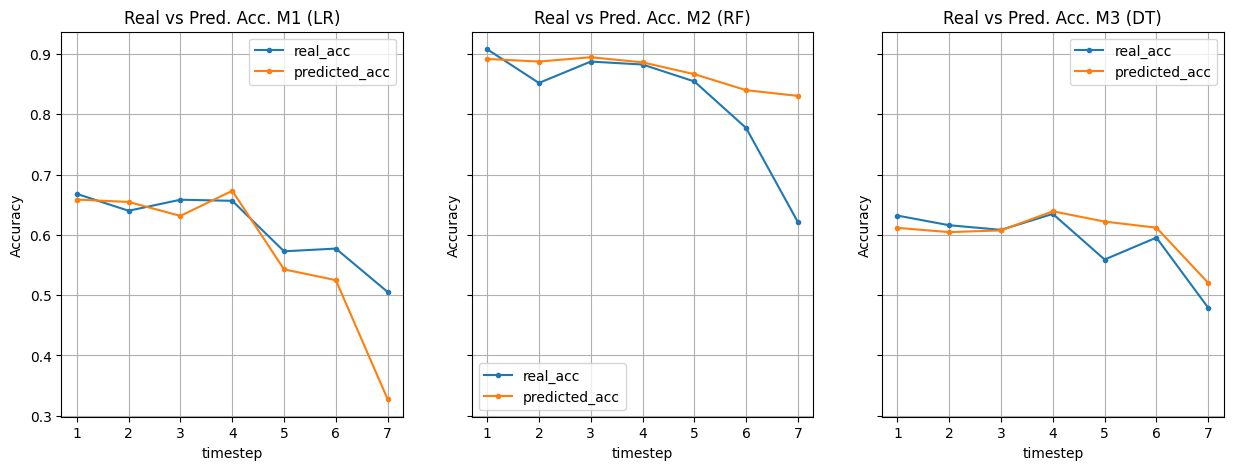

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

timesteps = list(range(1,8))
axs[0].plot(timesteps, real_accs_m1, label="real_acc", marker=".")
axs[0].plot(timesteps, predicted_accs_m1, label="predicted_acc", marker=".")
axs[0].set_title("Real vs Pred. Acc. M1 (LR)", size=12, loc='center')

axs[1].plot(timesteps, real_accs_m2, label="real_acc", marker=".")
axs[1].plot(timesteps, predicted_accs_m2, label="predicted_acc", marker=".")
axs[1].set_title("Real vs Pred. Acc. M2 (RF)", size=12, loc='center')

axs[2].plot(timesteps, real_accs_m3, label="real_acc", marker=".")
axs[2].plot(timesteps, predicted_accs_m3, label="predicted_acc", marker=".")
axs[2].set_title("Real vs Pred. Acc. M3 (DT)", size=12, loc='center')

for ax in axs.flat:
    ax.set(xlabel='timestep', ylabel='Accuracy')
    ax.grid()
    ax.legend()

We see:

- M1 (Logistic Regression): The predicted accuracy is often worse than the real accuracy. Although the predicted accuracy doesn't match exactly the real accuracy, the patterns increase/decrease seem correct. In this case, the method would be useful to realize that our model performance is degrading
- M2 (Random Forest): This is the case where method seems to be less useful, since there is a big drop on accuracy in the last time step which is not predicted by the `PerformancePredictor`.
- M3 (Decision Tree): As in the M1, the predicted accuracy is similar than the real accuracy.

In further analysis for the M2 case, we discovered that the accuracies when applying the corruptions never suffer from high performance drops, which makes the regressor task to predict future performance drops very difficult. The label predictions of M2 seem to be more stable in this model, which in a label shift scenario might make the model suffer a performance drop. Since this label shift is not represented in the corruptions and the predictions are stable, the `PerformancePredictor` is not able to predict the performance drop

<a id="experiment_3"></a>
## Experiment 3: Regression in synthetic Dataset

In this last experiment, we show that the method can be used also in a regression task. Furthermore, we will introduce a categorical variable and use a previously created `DataSchema`

### Create Dataset

Let's create a regression dataset using `make_regression`. We will create also an uncorrelated feature "f2" with 3 possible values

In [26]:
from sklearn.datasets import make_regression
X, y = make_regression(1000, n_features=2, n_informative=2, random_state=SEED)
X = pd.DataFrame(X, columns=["f" + str(i) for i in range(X.shape[1])])
# Introduce Random categorical variable for illustration purposes
X["f2"] = np.random.choice([0, 1, 2], size=len(X))
X_source, X_serving, y_source, y_serving = train_test_split(X, y, test_size=0.5, random_state=42)

Let's separate the serving dataset in two, and introduce data drift in Serving_2

In [27]:
# Split Serving and add Drift
X_serving_1 = X_serving.iloc[0:250].copy()
X_serving_2 = X_serving.iloc[250:].copy()
y_serving_1 = y_serving[0:250]
y_serving_2 = y_serving[250:]

In [28]:
from mercury.monitoring.drift.drift_simulation import BatchDriftGenerator

# Shift Drift in Feature f0 in X_serving_2
sim = BatchDriftGenerator(X_serving_2.copy()).shift_drift(cols=["f0"], force=10.0, noise=1.0)
X_serving_2 = sim.data.copy()

### Train Model

Now let's train the model

In [29]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X_source, y_source, test_size=0.3, random_state=42)
model = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42)
model = model.fit(X_train, y_train)

### Performance Prediction

This time, since we have a categorical variable, we will create the `DataSchema` ourselves to ensure that "f2" is treated as categorical variable. This will make that later the `PerformancePredictor` will introduce special corruptions for categorical variables

In [30]:
from mercury.dataschema import DataSchema
dataset_schema = DataSchema().generate_manual(
    dataframe=X_train, 
    categ_columns=["f2"], 
    discrete_columns=[], binary_columns=[])

Let's create the `PerformancePredictor` object.

In [31]:
from sklearn.metrics import mean_absolute_error
performance_predictor = PerformancePredictor(
    model, metric_fn=mean_absolute_error, 
    #performance_predictor = RandomForestRegressor(criterion='mae', random_state=SEED)
)

Let's use the performance predictor. As in experiment 2, we specify the serving dataset so the corruptions are generated automatically:

In [32]:
performance_predictor.fit(X=X_test, y=y_test, X_serving=X_serving_1, dataset_schema=dataset_schema)
predicted_mae_1 = performance_predictor.predict(X_serving_1)[0]
real_mae_1 = mean_absolute_error(y_serving_1, model.predict(X_serving_1))

performance_predictor.fit(X=X_test, y=y_test, X_serving=X_serving_2, dataset_schema=dataset_schema)
predicted_mae_2 = performance_predictor.predict(X_serving_2)[0]
real_mae_2 = mean_absolute_error(y_serving_2, model.predict(X_serving_2))

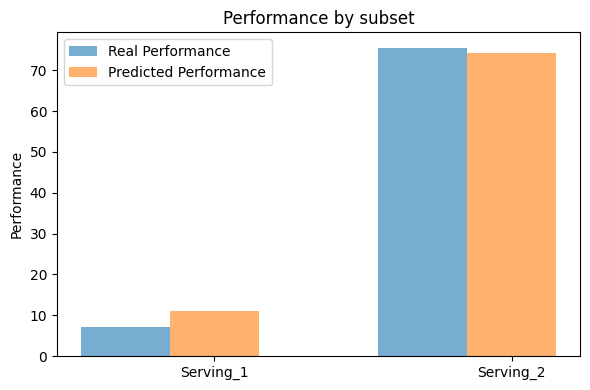

In [33]:
# data to plot
real_performance = [real_mae_1, real_mae_2]
predicted_performance = [predicted_mae_1, predicted_mae_2]

# create plot
fig, ax = plt.subplots(figsize=(6, 4))
index = np.arange(len(real_performance))
bar_width = 0.30

bar1 = plt.bar(index, real_performance, bar_width, alpha=0.6, label='Real Performance')
bar2 = plt.bar(index + bar_width, predicted_performance, bar_width,alpha=0.6, label='Predicted Performance')

plt.ylabel('Performance')
plt.title('Performance by subset')
plt.xticks(index + bar_width, ('Serving_1', 'Serving_2'))
plt.legend()

plt.tight_layout()
plt.show()

As we see, the mean absolute error predicted in serving 2 is much higher and close to the real

## Conclusions

We have seen that the method can sometimes predict an approximation of the real performance of the model.

However, we see that sometimes the performance is not 100% accurate and in some cases even can miss some big performance drops, as we saw in experiment 2 with model M2. This might happen in some cases where we experience different types of drift than covariate drift.

We still think that the method can be useful in some cases and can be one more metric to monitor in our model when we do not have the labels instantly.

# References

<a id="[1]">[1]</a> 
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.